## Import Modules

In [99]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from keras.callbacks import EarlyStopping
from IPython.display import Audio
from keras.models import Sequential,Model
from keras.layers import Dense, LSTM,SimpleRNN, Dropout,LayerNormalization,Input,Flatten
import tensorflow as tf
from keras.optimizers import Adam
from google.colab import drive
import zipfile
import warnings
warnings.filterwarnings('ignore')

## Retrieving Tess dataset from google drive.
Acknowledgements.
Showing gratitude to the University of Toronto for putting together this awesome dataset!
Toronto emotional speech set (TESS), Kate Dupuis, M. Kathleen Pichora-Fuller, University of Toronto, Psychology Department, 2010, [Toronto emotional speech set (TESS) | TSpace Repository (utoronto.ca)]


In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
# Path to the uploaded zip file
zip_path = '/content/drive/My Drive/Colab Notebooks/tess.zip'
extract_path = '/content/TESS/'

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
os.listdir(extract_path)

['tess']

## Load the Dataset

In [102]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/TESS'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [103]:
print("Total number of audio(.wav) files :",len(paths))
print("Total number of labels/classes :",len(set(labels)))

Total number of audio(.wav) files : 5600
Total number of labels/classes : 7


In [104]:
## Creating a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

In [105]:
df['label'].value_counts()

label
happy      800
sad        800
ps         800
disgust    800
angry      800
neutral    800
fear       800
Name: count, dtype: int64

## Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

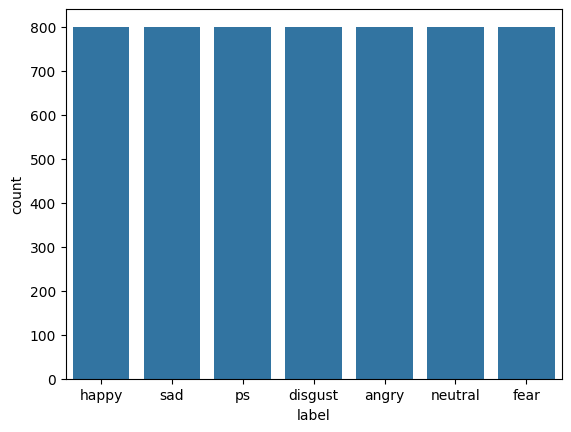

In [106]:
sns.countplot(data=df, x='label')

In [107]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

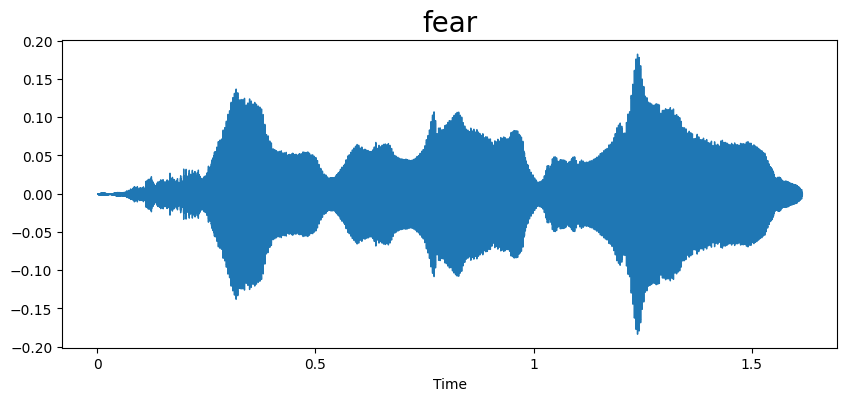

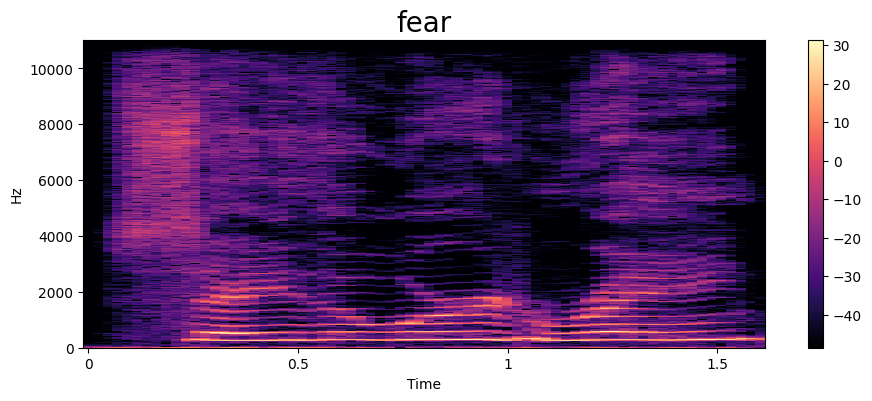

In [108]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

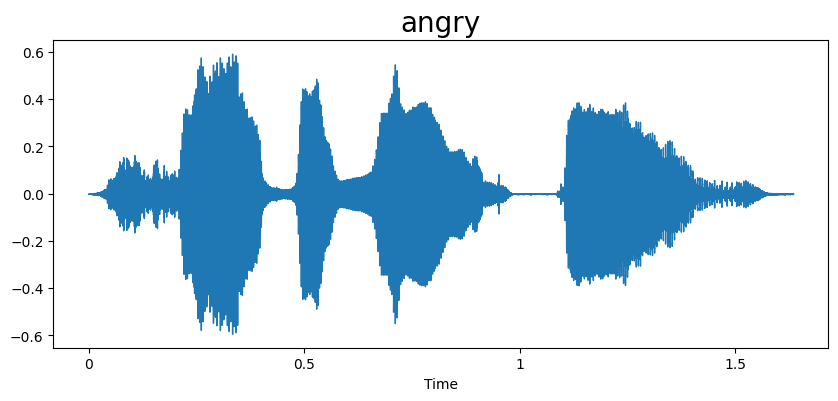

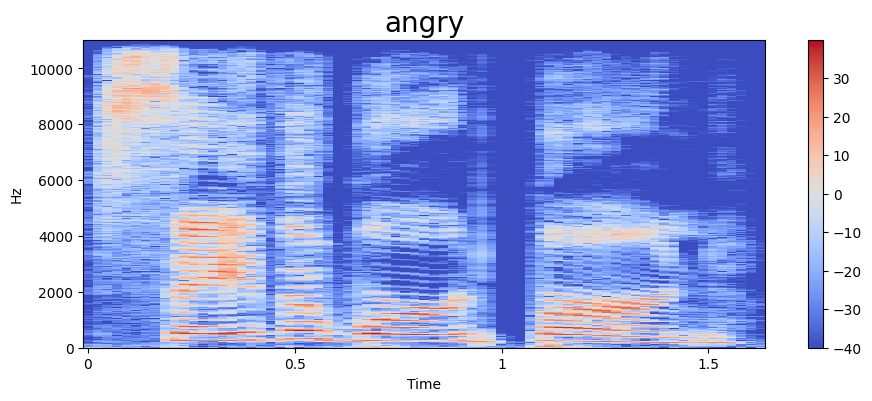

In [109]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

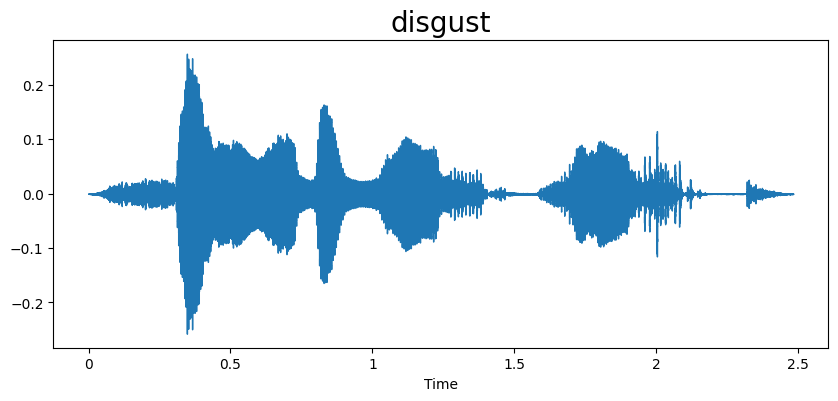

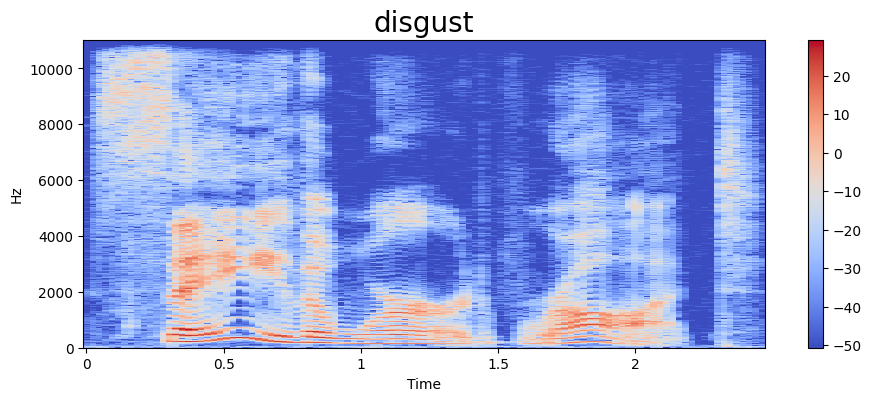

In [110]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

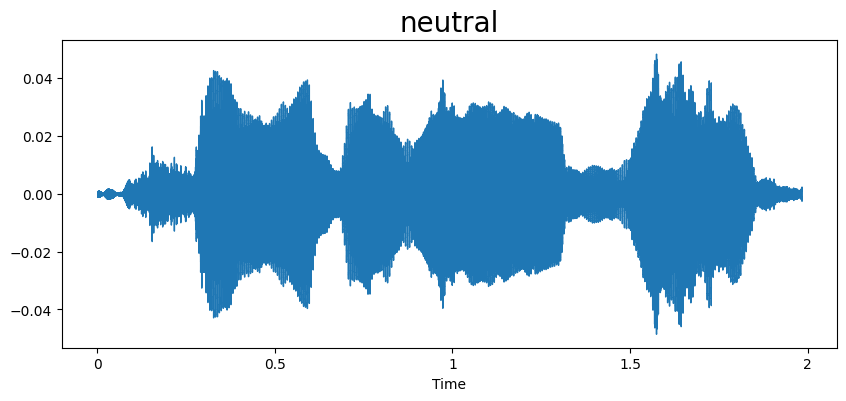

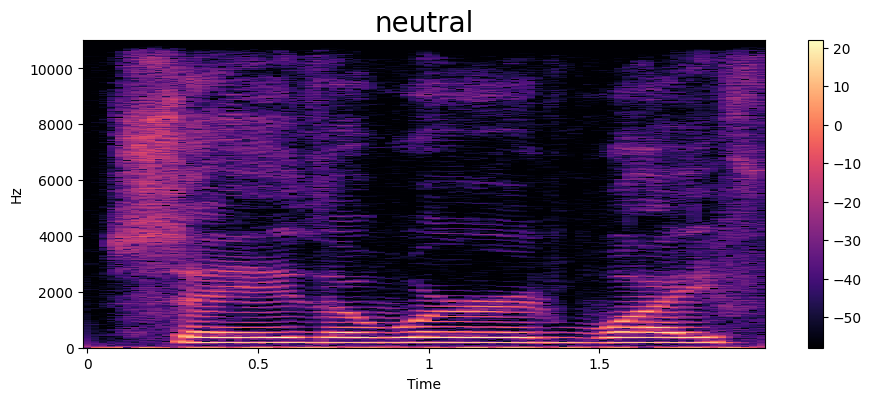

In [111]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

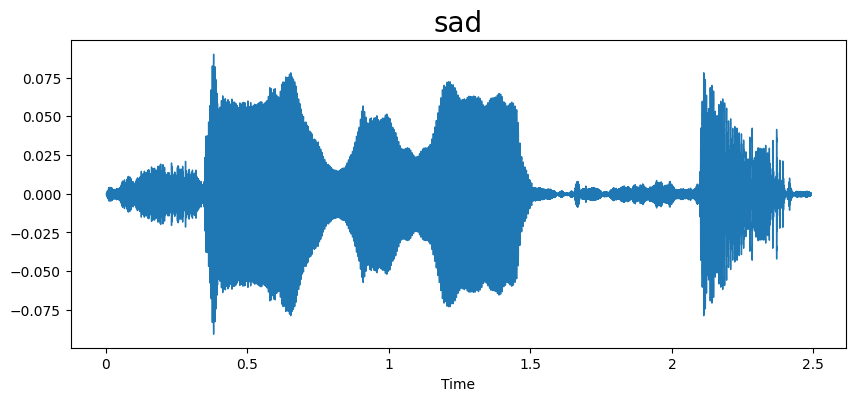

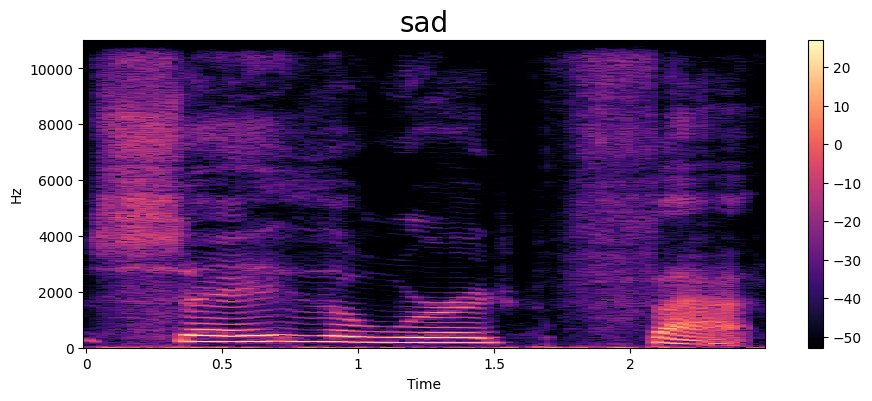

In [112]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

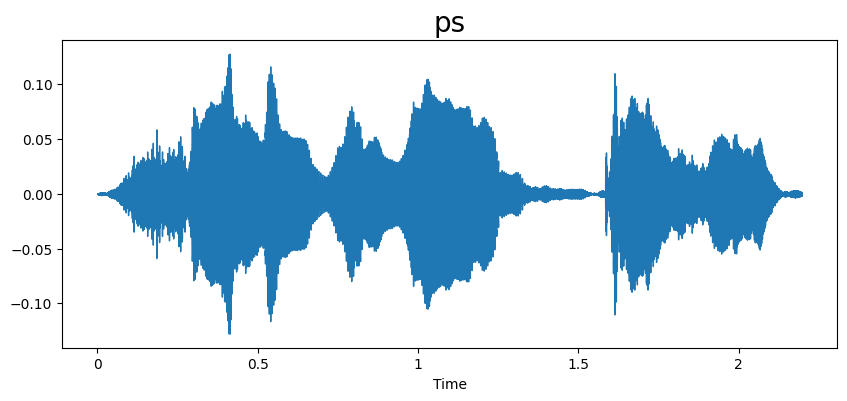

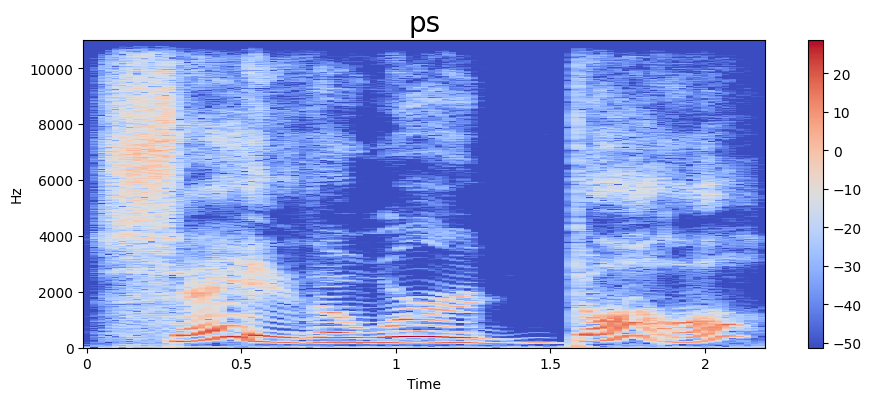

In [113]:
emotion = 'ps'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

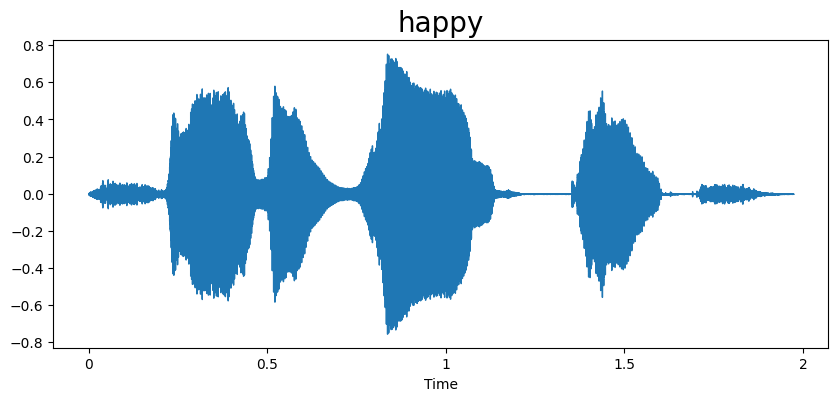

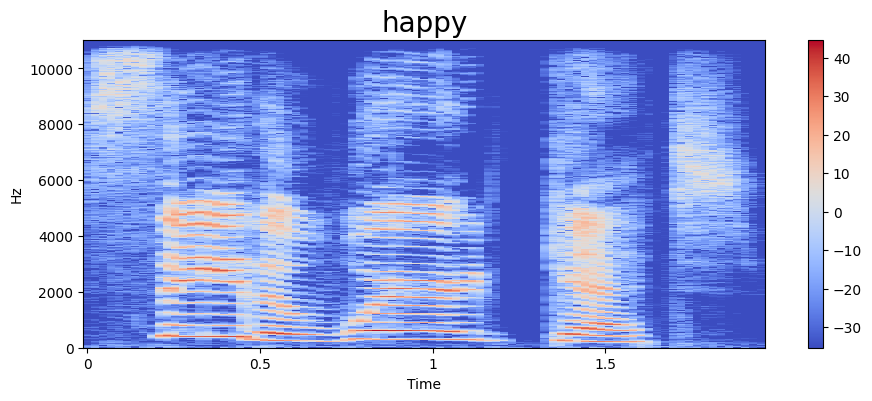

In [114]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Feature Extraction

In [115]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [116]:
extract_mfcc(df['speech'][0])

array([-310.4251    ,   28.0223    ,  -16.727142  ,   26.728197  ,
        -17.578539  ,   -1.9525276 ,  -13.414606  ,  -12.983517  ,
          6.2140923 ,  -12.074405  ,   -5.7360964 ,   10.12517   ,
         -9.190622  ,    4.79706   ,   -6.695942  ,   -4.325102  ,
         -4.609931  ,   -7.559399  ,  -11.934643  ,   -0.95110846,
         -5.1330514 ,    3.4920936 ,    6.8124723 ,   11.553335  ,
          8.855418  ,    5.471767  ,    1.157383  ,    3.7892685 ,
          8.5634775 ,   11.414459  ,    5.786418  ,    2.1260612 ,
         -1.1350731 ,    3.3661072 ,    2.9671896 ,    1.3050308 ,
         -6.139388  ,   -5.609858  ,   -2.2548792 ,    3.1850648 ],
      dtype=float32)

In [117]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [118]:
X_mfcc[:5]

0    [-310.4251, 28.0223, -16.727142, 26.728197, -1...
1    [-293.00516, 61.23745, -23.379162, 15.216217, ...
2    [-334.04364, 64.73749, -20.572914, 13.049891, ...
3    [-333.50607, 51.257378, -12.526289, 35.46645, ...
4    [-339.13574, 47.384403, -22.589619, 28.021807,...
Name: speech, dtype: object

In [119]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(5600, 40)

In [120]:
## input split
X = np.expand_dims(X, -1)
X.shape

(5600, 40, 1)

In [121]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()
print("labels: ")
print(np.unique(y,axis=0))


labels: 
[[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [122]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [123]:
y.shape

(5600, 7)

## Create the LSTM Model

In [124]:


model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_26 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 64)                8256      
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 7)                

In [125]:
# Train the model
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64,callbacks=[early_stopping])

Epoch 1/50
70/70 [==============================] - 16s 195ms/step - loss: 0.8883 - accuracy: 0.6556 - val_loss: 0.2653 - val_accuracy: 0.9036
Epoch 2/50
70/70 [==============================] - 10s 148ms/step - loss: 0.2524 - accuracy: 0.9187 - val_loss: 0.1383 - val_accuracy: 0.9536
Epoch 3/50
70/70 [==============================] - 11s 164ms/step - loss: 0.1498 - accuracy: 0.9567 - val_loss: 0.1479 - val_accuracy: 0.9518
Epoch 4/50
70/70 [==============================] - 12s 177ms/step - loss: 0.1545 - accuracy: 0.9556 - val_loss: 0.1344 - val_accuracy: 0.9571
Epoch 5/50
70/70 [==============================] - 12s 177ms/step - loss: 0.0994 - accuracy: 0.9705 - val_loss: 0.0602 - val_accuracy: 0.9795
Epoch 6/50
70/70 [==============================] - 11s 158ms/step - loss: 0.0773 - accuracy: 0.9741 - val_loss: 0.0773 - val_accuracy: 0.9714
Epoch 7/50
70/70 [==============================] - 11s 150ms/step - loss: 0.0810 - accuracy: 0.9741 - val_loss: 0.0459 - val_accuracy: 0.9857

## Plot the results

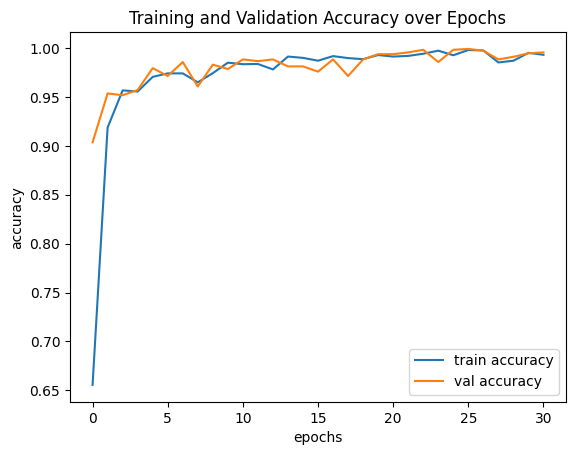

In [126]:
epochs = list(range(len(history.history['loss'])))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


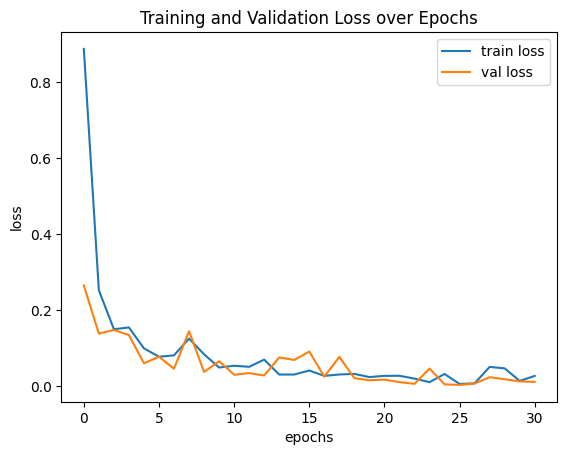

In [127]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [128]:
rnn_model = Sequential([
    SimpleRNN(256, return_sequences=False, input_shape=(40, 1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.summary()
history = rnn_model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64,callbacks=[early_stopping])


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 256)               66048     
                                                                 
 dropout_29 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               32896     
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 7)                

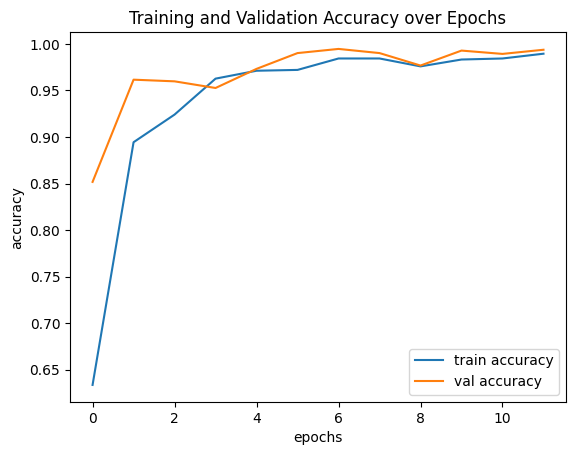

In [129]:
epochs = list(range(len(history.history['loss'])))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

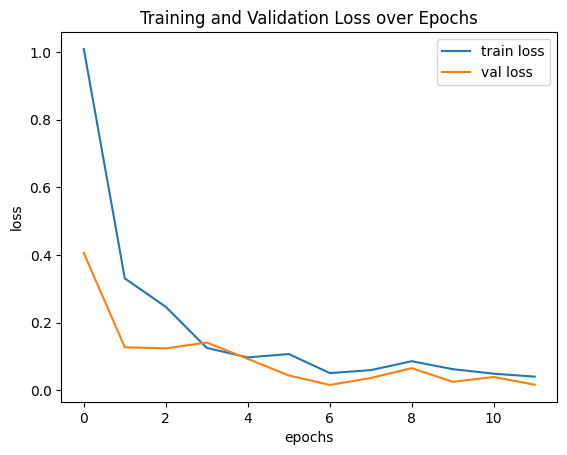

In [130]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [131]:


def get_positional_encoding(max_position, d_model):
    angles = np.arange(max_position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angles[:, 0::2] = np.sin(angles[:, 0::2])
    angles[:, 1::2] = np.cos(angles[:, 1::2])
    return tf.constant(angles, dtype=tf.float32)

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.1)(x)
    x = TransformerBlock(embed_dim=64, num_heads=2, ff_dim=128)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (40, 1)
num_classes = y.shape[1]
transformer_model = build_transformer_model(input_shape, num_classes)
transformer_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
transformer_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = transformer_model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64, callbacks=[early_stopping])


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 1)]           0         
                                                                 
 dense_34 (Dense)            (None, 40, 64)            128       
                                                                 
 dropout_32 (Dropout)        (None, 40, 64)            0         
                                                                 
 transformer_block_2 (Trans  (None, 40, 64)            50048     
 formerBlock)                                                    
                                                                 
 flatten_2 (Flatten)         (None, 2560)              0         
                                                                 
 dense_37 (Dense)            (None, 128)               327808    
                                                           

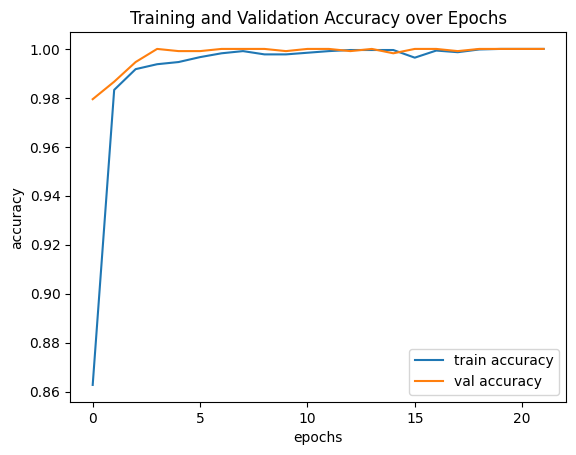

In [132]:
epochs = list(range(len(history.history['loss'])))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

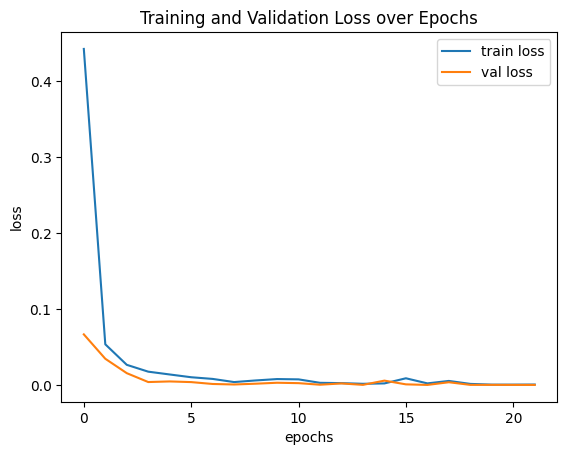

In [133]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()